In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install hvplot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.6 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-58v2sc5q
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-58v2sc5q
  Resolved https://github.com/paulgavrikov/visualkeras to commit 0ffcf1adc61c98068f8984a3646fcf3b46f01420
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 16.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13782 sha256=a0ccc30757bf36de3be65a4fcfa335a38ab38eecda36982cbfe13ee6c015711b
  Stored in directory: /tmp/pip-ephem-wheel-cache-da_n34x6/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


In [6]:
import numpy as np
import pandas as pd
import os

# Tensorflow, Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications import VGG16, ResNet101V2

# Sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# Plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageFile, Image
import hvplot.pandas
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import visualkeras
# Set LOAD_TRUNCATED_IMAGES to true
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [7]:
train_path = "../input/wildfire-prediction-dataset/train"
valid_path = "../input/wildfire-prediction-dataset/valid"
test_path = "../input/wildfire-prediction-dataset/test"

**GEOSPATIAL ANALYSIS**

In [8]:
path=[]
filenames=[]
longitude=[]
latitude=[]
folder_path="../input/wildfire-prediction-dataset/"

# Iterate through subdirectories and files
for entry in os.scandir(folder_path):
    if entry.is_dir():
        subfolder_path = os.path.join(folder_path, entry.name)
        for sub_entry in os.scandir(subfolder_path):
            if sub_entry.is_dir():
                for file in enumerate(os.listdir(sub_entry.path)):
                    # Append the file name to the DataFrame$
                    path.append(sub_entry.path+'/'+file[1])
                    filenames.append(file[1])
                    parts = file[1].split(',')
                    longitude.append(parts[0])
                    latitude.append(parts[1].split('.jp')[0])

df_pictures = pd.DataFrame({'Filename': filenames, 'Longitude': longitude, 'Latitude': latitude, 'Path': path})
# Convert 'Longitude' and 'Latitude' columns to numerical values
df_pictures['Longitude'] = pd.to_numeric(df_pictures['Longitude'])
df_pictures['Latitude'] = pd.to_numeric(df_pictures['Latitude'])


In [9]:
df_pictures

,Filename,Longitude,Latitude,Path
0,"-73.71631,46.04137.jpg",-73.716310,46.041370,../input/wildfire-prediction-dataset/valid/wil...
1,"-74.62281,45.80216.jpg",-74.622810,45.802160,../input/wildfire-prediction-dataset/valid/wil...
2,"-70.19693,53.61931.jpg",-70.196930,53.619310,../input/wildfire-prediction-dataset/valid/wil...
3,"-71.15229,46.51529.jpg",-71.152290,46.515290,../input/wildfire-prediction-dataset/valid/wil...
4,"-71.70749,45.72332.jpg",-71.707490,45.723320,../input/wildfire-prediction-dataset/valid/wil...
...,...,...,...,...
42845,"-79.504062,43.815677.jpg",-79.504062,43.815677,../input/wildfire-prediction-dataset/train/now...
42846,"-75.741689,45.367119.jpg",-75.741689,45.367119,../input/wildfire-prediction-dataset/train/now...
42847,"-123.078186,49.197516.jpg",-123.078186,49.197516,../input/wildfire-prediction-dataset/train/now...
42848,"-122.736563,49.177259.jpg",-122.736563,49.177259,../input/wildfire-prediction-dataset/train/now...


/tmp/ipykernel_34/712328175.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


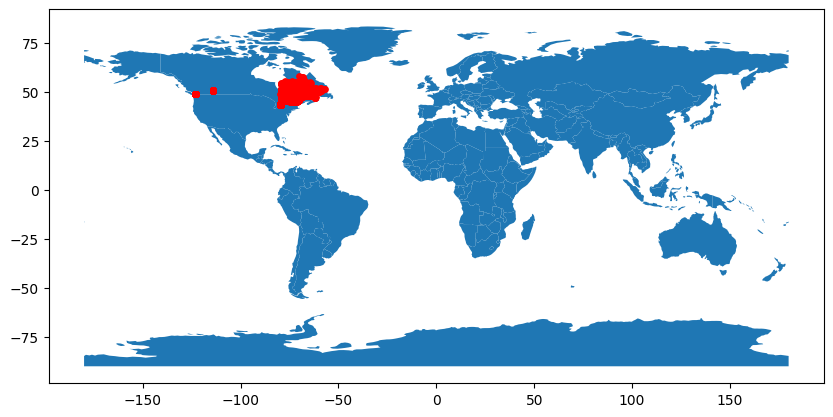

In [10]:
geometry = [Point(xy) for xy in zip(df_pictures['Longitude'], df_pictures['Latitude'])]
gdf = GeoDataFrame(df_pictures, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);


In [11]:

rescale_datagen = ImageDataGenerator(
    dtype='float32',                # Data type for the output data
    rescale=1./255.,                # Rescale pixel values to the range [0, 1]
    rotation_range=10,              # Randomly rotate images by up to 10 degrees
    zoom_range=0.05,                # Randomly zoom in/out on images by 5%
    width_shift_range=0.1,          # Randomly shift the width of images by 10%
    height_shift_range=0.1,         # Randomly shift the height of images by 10%
    shear_range=0.15,               # Randomly apply shear transformations
    horizontal_flip=True,           # Randomly flip images horizontally
    fill_mode="nearest"             # Strategy for filling in newly created pixels
)
train_generator = rescale_datagen.flow_from_directory(train_path,
                                                      batch_size = 50, 
                                                      target_size = (224,224),
                                                      color_mode = "rgb",
                                                      class_mode = "categorical",
                                                      shuffle = True,
                                                      seed = 42)
valid_generator = rescale_datagen.flow_from_directory(valid_path,
                                                      batch_size = 50,
                                                      target_size = (224,224),
                                                      color_mode = "rgb",
                                                      class_mode = "categorical",
                                                      shuffle = True,
                                                      seed = 42)
test_generator = rescale_datagen.flow_from_directory(test_path,
                                                     batch_size = 50,
                                                     target_size = (224,224),
                                                     color_mode = "rgb",
                                                     class_mode = "categorical",
                                                     shuffle = False,
                                                     seed = 42)


Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [12]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['nowildfire', 'wildfire']

In [13]:
# Calculate class weights
class_labels = np.unique(valid_generator.classes)
class_distribution = np.bincount(train_generator.classes) + np.bincount(valid_generator.classes) + np.bincount(test_generator.classes)
total_samples = np.sum(class_distribution)
class_weights = total_samples / (len(class_labels) * class_distribution)

class_weights /= np.sum(class_weights)

# Create a dictionary of class weights
class_weight_dict = {class_index: weight for class_index, weight in enumerate(np.round(class_weights,2))}
class_weight_dict

{0: 0.53, 1: 0.47}

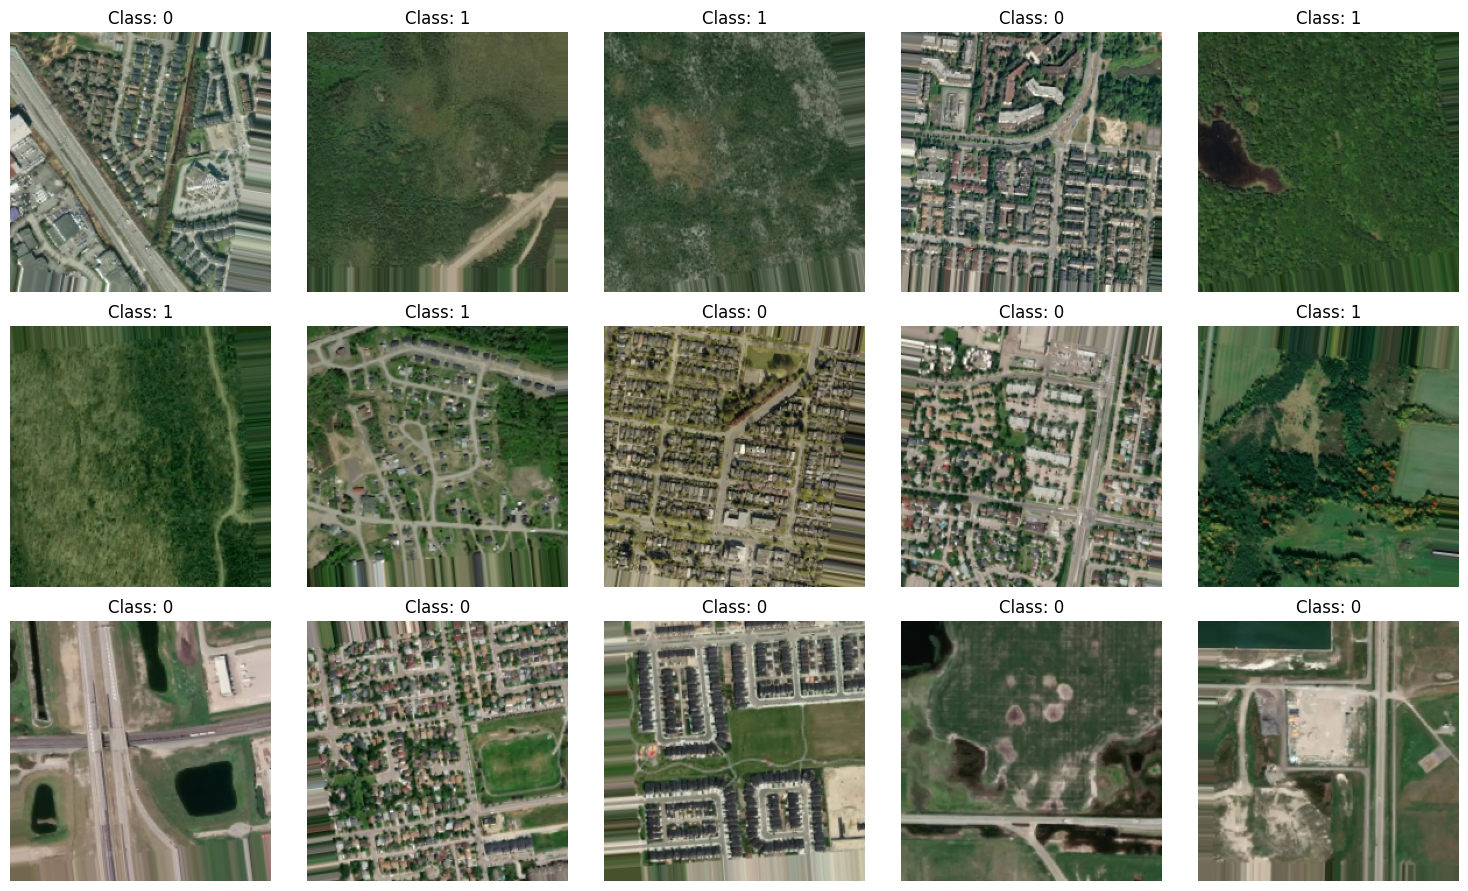

In [14]:
import matplotlib.pyplot as plt
import random

# Set the number of random images to plot
num_images_to_plot = 5

# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, num_images_to_plot, figsize=(15, 9))  # Adjust figsize as needed

# Iterate through the generator to get random images
for i in range(3):
    for j in range(num_images_to_plot):
        # Get a random batch based on the row (train, valid, or test)
        if i == 0:
            batch = next(train_generator)
        elif i == 1:
            batch = next(valid_generator)
        else:
            batch = next(test_generator)
        
        images, labels = batch
        
        # Select a random image from the batch
        random_index = random.randint(0, len(images) - 1)
        image_to_plot = images[random_index]
        label_to_plot = labels[random_index]

        # Plot the selected image on the corresponding subplot
        axes[i, j].imshow(image_to_plot)
        axes[i, j].set_title(f"Class: {label_to_plot.argmax()}")  # Assuming one-hot encoded labels
        axes[i, j].axis('off')  # Turn off axis labels

# Adjust spacing between subplots for better layout
plt.tight_layout()
plt.show()

In [12]:
# building neural networks
random_normal_initializer = RandomNormal(mean=0.0, stddev=0.05)
cnn_model = Sequential([
    # Conv layer 1:
    Conv2D(32, (3, 3), input_shape=(250,250,3), activation='elu', kernel_initializer =random_normal_initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 2:
    Conv2D(16, (3, 3), activation='elu', kernel_initializer =random_normal_initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 3:
    Conv2D(16, (3, 3), activation='elu', kernel_initializer =random_normal_initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    
    Flatten(),
    
    # fully connected layers:
    Dense(units = 128, activation = 'elu'),
    Dense(units = 2, activation = 'softmax')
])


cnn_model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 248, 248, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 122, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,730,850 (6.60 MB)

 Trainable params: 1,730,722 (6.60 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

logs1 = cnn_model.fit(train_generator,
                   epochs = 20,
                   steps_per_epoch=int(30250/50),
                   validation_data = valid_generator,
                   validation_steps=int(6300/50),
                   callbacks=[callback])

In [ ]:
training_accuracy = logs1.history['accuracy']
validation_accuracy = logs1.history['val_accuracy']

# Get the training and validation loss
training_loss = logs1.history['loss']
validation_loss = logs1.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
result = cnn_model.evaluate(test_generator, steps=6300/50)

In [ ]:
test_generator.reset()
prediction2 = cnn_model.predict(test_generator)
y_prediction2 = np.argmax(prediction2, axis=1)

conf_matrix = confusion_matrix(y_true=test_generator.classes, y_pred=y_prediction2)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()

In [ ]:
acc_cnn_model = accuracy_score(y_true=test_generator.classes, y_pred=y_prediction2)
print(f"Accuracy of CNN model: {acc_cnn_model*100:.1f}%")

In [15]:
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications import ResNet101
from keras.optimizers import Adam

# Load pre-trained ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    layer_output = layer.output    
#     print(layer.name, layer_output.shape)

# Add your custom dense layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['AUC','accuracy'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 94,104,834 (358.98 MB)

 Trainable params: 51,446,658 (196.25 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

logs2 = model.fit(train_generator,
                   epochs = 10,
                   steps_per_epoch=int(30250/50),
                   validation_data = valid_generator,
                   validation_steps=int(6300/50),
                   callbacks=[callback])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/605 ━━━━━━━━━━━━━━━━━━━━ 5:09:33 31s/step - AUC: 0.6416 - accuracy: 0.5400 - loss: 0.7790

I0000 00:00:1713969455.483947      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713969455.571727      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - AUC: 0.8489 - accuracy: 0.8075 - loss: 1.3595

W0000 00:00:1713969970.033867     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


605/605 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - AUC: 0.8490 - accuracy: 0.8076 - loss: 1.3583 - val_AUC: 0.9444 - val_accuracy: 0.8817 - val_loss: 0.3046
Epoch 2/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


605/605 ━━━━━━━━━━━━━━━━━━━━ 445s 729ms/step - AUC: 0.9280 - accuracy: 0.8667 - loss: 0.3398 - val_AUC: 0.9478 - val_accuracy: 0.8722 - val_loss: 0.3313
Epoch 4/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 430s 705ms/step - AUC: 0.9371 - accuracy: 0.8722 - loss: 0.3188 - val_AUC: 0.9565 - val_accuracy: 0.8873 - val_loss: 0.2696
Epoch 6/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
605/605 ━━━━━━━━━━━━━━━━━━━━ 430s 705ms/step - AUC: 0.9423 - accuracy: 0.8785 - loss: 0.3049 - val_AUC: 0.9505 - val_accuracy: 0.8897 - val_loss: 0.2817
Epoch 8/10


126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 561ms/step


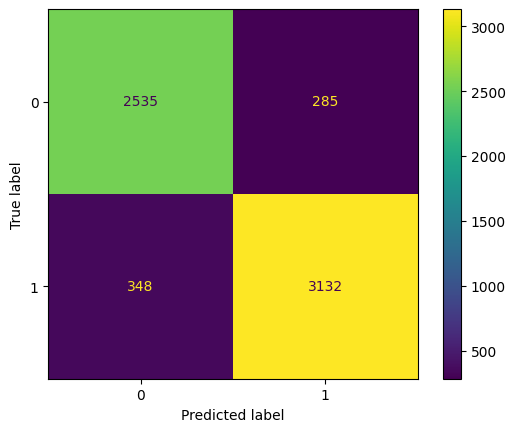

In [18]:
# resnet101_model= load_model("Model_resnet.h5")
test_generator.reset()
prediction4 = model.predict(test_generator)
y_prediction4 = np.argmax(prediction4, axis=1)

conf_matrix = confusion_matrix(y_true=test_generator.classes, y_pred=y_prediction4)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()

In [20]:
model.save("imported_model.keras")

In [19]:
acc_resnet = accuracy_score(y_true=test_generator.classes, y_pred=y_prediction4)
print(f"Accuracy of Resnet model: {acc_resnet*100:.1f}%")

Accuracy of Resnet model: 90.0%


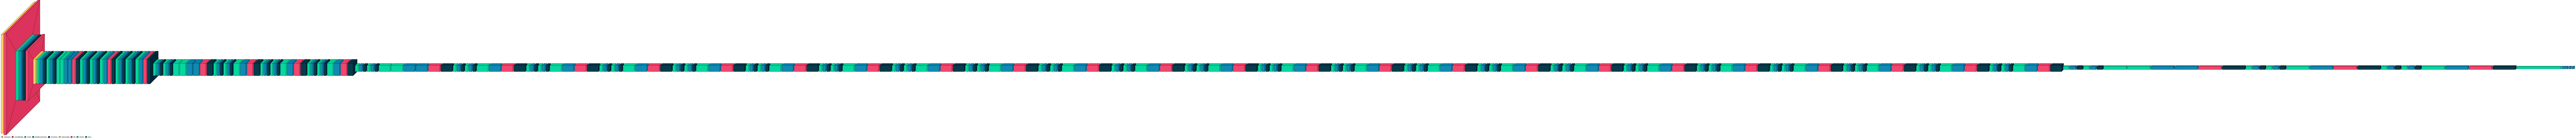

In [22]:
visualkeras.layered_view(model,legend=True, to_file='ResNet101.png')

In [ ]:
resnet101.save("imported_model.keras")

In [23]:
from keras.models import load_model

# Load the HDF5 model
loaded_model = load_model('/kaggle/working/imported_model.keras')

test_generator.reset()
prediction_3 = loaded_model.predict(test_generator)

acc_loaded_resnet = accuracy_score(y_true=test_generator.classes, y_pred=prediction_3)
print(f"Accuracy of Resnet model: {acc_loaded_resnet*100:.1f}%")

  2/126 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step 

W0000 00:00:1713972234.893598     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/126 ━━━━━━━━━━━━━━━━━━━━ 78s 564ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets